### DataSet Sources

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset

- 2,476 items (Covid-CT Scan)
- 2,173 items (Non-Covid-CT Scan)

### Importing Relevant Libraries

In [1]:
import pandas as pd
import cv2
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
#from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import os
import argparse
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
K.set_image_data_format('channels_last')


2023-07-25 16:17:03.234784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 16:17:03.332116: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 16:17:03.773564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rkannan/miniconda3/envs/richard_tf/lib/python3.9/site-packages/cv2/../../lib64::/

python 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
keras version 2.11.0
tensorflow version 2.11.0


### Loading the Dataset and Preprocessing

In [2]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))

path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_NonCOVID/'
prefix2 = 'ct_noncovid'

In [3]:
def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df


ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
display(cvd_imgs_dataset)

input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((4649,300,300,1))
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
cvd_imgs_dataset = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
output_label_y = np.array(cvd_imgs_dataset[['output_encode_0','output_encode_1']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))

,0,1,2,3,4,5,6,7,8,9,...,89991,89992,89993,89994,89995,89996,89997,89998,89999,class_label
COVID-19_0155.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Non-Covid (371).png,64,64,64,64,64,64,64,64,64,65,...,72,72,72,72,72,72,72,72,72,0
Non-COVID-19_066.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Non-COVID-19_781.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COVID-19_0401.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Non-COVID-19_089.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Non-COVID-19_662.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Covid (372).png,191,190,181,182,193,180,192,198,204,207,...,197,194,194,189,196,181,195,199,191,1
Covid (916).png,64,64,64,65,66,67,67,68,67,67,...,68,70,71,69,69,70,72,72,72,1


Input_x Data Shape: 
(4649, 300, 300, 1)
Output_y Data Shape: 
(4649, 2)


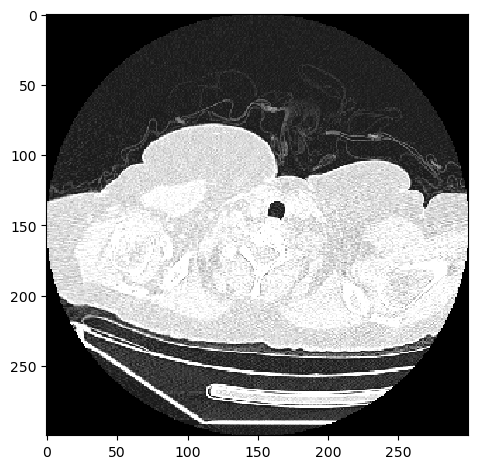

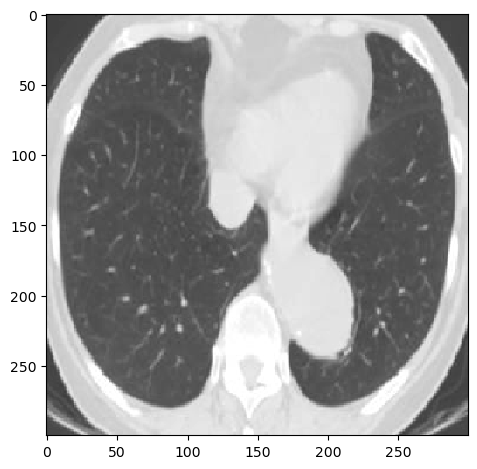

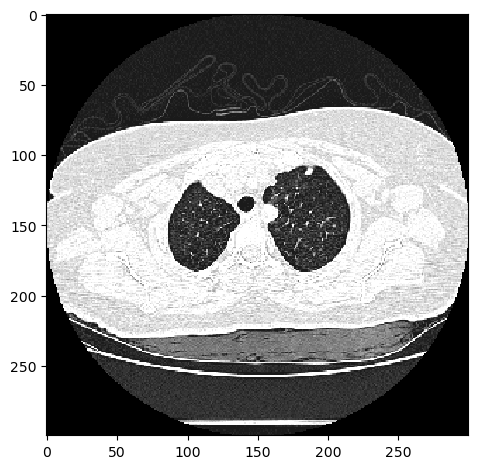

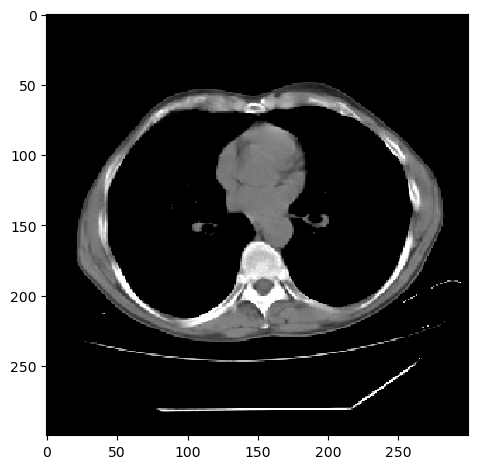

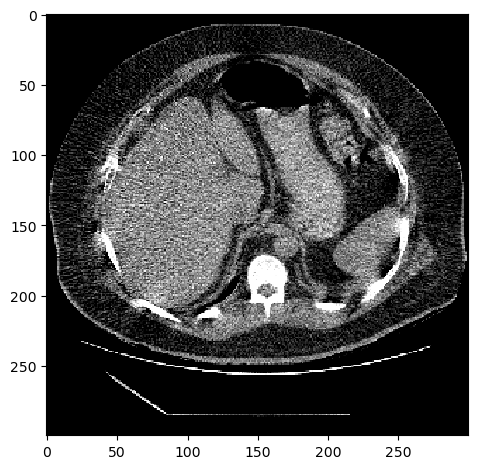

In [4]:
for i in range(5):
    imshow(input_data_x[i])
    show()

### Splitting Data into Training and Test

In [5]:
from sklearn.model_selection import train_test_split
def splitData(input_data_x_, output_label_y_):
    x_train, x_test, y_train, y_test = train_test_split(input_data_x_, output_label_y_, test_size=.20, random_state=42)
    return (x_train, x_test), (y_train, y_test)

In [6]:
def get_data():
    # the data, shuffled and split between train and test sets
    from tensorflow.keras.datasets import mnist
    (x_train, x_test), (y_train, y_test) = splitData(input_data_x, output_label_y)
    #return x_train, x_test, y_train, y_test

    x_train = x_train[0:3200,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    x_test = x_test[0:920,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    y_train = y_train.astype('float32')[0:3200,:]
    y_test = y_test.astype('float32')[0:920,:]
    return (x_train, y_train), (x_test, y_test)


In [7]:
# load data
(x_train, y_train), (x_test, y_test) = get_data()
print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)
#(3254, 300, 300, 1) (3254, 2) (1395, 300, 300, 1) (1395, 2)

(3200, 300, 300, 1) (3200, 2) (920, 300, 300, 1) (920, 2)


### Capsule Network Development

#### Capsule Layers

- https://fairyonice.github.io/Understanding-and-Experimenting-Capsule-Networks.html
- https://www.youtube.com/watch?v=VKoLGnq15RM&t=912s
- https://jhui.github.io/2017/11/03/Dynamic-Routing-Between-Capsules/
- https://www.kaggle.com/code/kmader/capsulenet-on-mnist/notebook

In [8]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.

Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))
        #print('From Me',inputs_hat.shape)
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    print(outputs.shape)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""


'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

### Capsule Network

In [9]:

'''
Hyperparameters

Convolution Layer filter Count: : 106
Convolution Layer Kernel Size: : 6
Stride_ Size Convolution Layer: : 2
Stride_ Size Primary Capsule: : 2
routing_val: : 7
Decoder Layer 1 Units: 628
Decoder Layer 2 Units: 1448
lr: 0.001064620944638055
Score: 0.9284615516662598

'''

'\nHyperparameters\n\nConvolution Layer filter Count: : 106\nConvolution Layer Kernel Size: : 6\nStride_ Size Convolution Layer: : 2\nStride_ Size Primary Capsule: : 2\nrouting_val: : 7\nDecoder Layer 1 Units: 628\nDecoder Layer 2 Units: 1448\nlr: 0.001064620944638055\nScore: 0.9284615516662598\n\n'

In [10]:
# image_size = 300
# data_augmentation = keras.Sequential(
#     [
#         tf.keras.layers.Normalization(),
#         tf.keras.layers.Resizing(image_size, image_size),
#         tf.keras.layers.RandomFlip("horizontal"),
#         tf.keras.layers.RandomRotation(factor=0.02),
#         tf.keras.layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )
# # Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

In [11]:
def CapsNet(input_shape, n_class, routings, batch_size):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :param batch_size: size of batch
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape, batch_size=batch_size)
    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=106, kernel_size=6, strides=2, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=6, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(628, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1448, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
    #decoder.summary()

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    return train_model, eval_model

In [12]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

### Training

In [13]:
def train(model,  # type: models.Model
          data, args=None):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('result/log.csv')
    checkpoint = callbacks.ModelCheckpoint('result'+ '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * (0.9 ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=0.0010646209),
                  loss=[margin_loss, 'binary_crossentropy'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})


#     # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=20, epochs=100,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, checkpoint, lr_decay])
    

    model.save_weights('result' + '/trained_model_july1.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % 'result')

    from utils import plot_log
    plot_log('result' + '/log.csv', show=True)

    return model

### Puting it all Together

##### Define Model

##### Train

2023-07-24 14:56:09.735018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 14:56:11.433552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14759 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-07-24 14:56:11.434189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14759 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-24 14:56:11.434656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
(5, 165888, 8)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1
2023-07-24 14:56:27.472280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-24 14:56:28.600338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-24 14:56:29.832190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-24 14:56:31.693603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-24 14:56:34.942630: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa12aa66850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-24 14:56:34.942679: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-07-24 14:56:34.942691: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device 

160/160 [==============================] - ETA: 0s - loss: 0.6574 - capsnet_loss: 0.4032 - decoder_loss: 0.6486 - capsnet_accuracy: 0.5309WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 60s 251ms/step - loss: 0.6574 - capsnet_loss: 0.4032 - decoder_loss: 0.6486 - capsnet_accuracy: 0.5309 - val_loss: 0.6126 - val_capsnet_loss: 0.4049 - val_decoder_loss: 0.5297 - val_capsnet_accuracy: 0.5152 - lr: 0.0010
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 0.5989 - capsnet_loss: 0.3988 - decoder_loss: 0.5107 - capsnet_accuracy: 0.4625WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 37s 230ms/step - loss: 0.5989 - capsnet_loss: 0.3988 - decoder_loss: 0.5107 - capsnet_accuracy: 0.4625 - val_loss: 0.5955 - val_capsnet_loss: 0.3887 - val_decoder_loss: 0.5278 - val_capsnet_accuracy: 0.5707 - lr: 9.0000e-04
Epoch 3/100
160/160 [==============================] - ETA: 0s - loss: 0.4248 - capsnet_loss: 0.2161 - decoder_loss: 0.5322 - capsnet_accuracy: 0.6834WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 227ms/step - loss: 0.4248 - capsnet_loss: 0.2161 - decoder_loss: 0.5322 - capsnet_accuracy: 0.6834 - val_loss: 0.3458 - val_capsnet_loss: 0.1476 - val_decoder_loss: 0.5059 - val_capsnet_accuracy: 0.7348 - lr: 8.1000e-04
Epoch 4/100
160/160 [==============================] - ETA: 0s - loss: 0.3110 - capsnet_loss: 0.1161 - decoder_loss: 0.4971 - capsnet_accuracy: 0.8200WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.3110 - capsnet_loss: 0.1161 - decoder_loss: 0.4971 - capsnet_accuracy: 0.8200 - val_loss: 0.2931 - val_capsnet_loss: 0.1016 - val_decoder_loss: 0.4885 - val_capsnet_accuracy: 0.8457 - lr: 7.2900e-04
Epoch 5/100
160/160 [==============================] - ETA: 0s - loss: 0.2822 - capsnet_loss: 0.0917 - decoder_loss: 0.4859 - capsnet_accuracy: 0.8666WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.2822 - capsnet_loss: 0.0917 - decoder_loss: 0.4859 - capsnet_accuracy: 0.8666 - val_loss: 0.2706 - val_capsnet_loss: 0.0823 - val_decoder_loss: 0.4803 - val_capsnet_accuracy: 0.8870 - lr: 6.5610e-04
Epoch 6/100
160/160 [==============================] - ETA: 0s - loss: 0.2650 - capsnet_loss: 0.0765 - decoder_loss: 0.4809 - capsnet_accuracy: 0.8894WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.2650 - capsnet_loss: 0.0765 - decoder_loss: 0.4809 - capsnet_accuracy: 0.8894 - val_loss: 0.2708 - val_capsnet_loss: 0.0840 - val_decoder_loss: 0.4763 - val_capsnet_accuracy: 0.8685 - lr: 5.9049e-04
Epoch 7/100
160/160 [==============================] - ETA: 0s - loss: 0.2509 - capsnet_loss: 0.0645 - decoder_loss: 0.4755 - capsnet_accuracy: 0.9103WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.2509 - capsnet_loss: 0.0645 - decoder_loss: 0.4755 - capsnet_accuracy: 0.9103 - val_loss: 0.2682 - val_capsnet_loss: 0.0828 - val_decoder_loss: 0.4730 - val_capsnet_accuracy: 0.8891 - lr: 5.3144e-04
Epoch 8/100
160/160 [==============================] - ETA: 0s - loss: 0.2363 - capsnet_loss: 0.0512 - decoder_loss: 0.4721 - capsnet_accuracy: 0.9347WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.2363 - capsnet_loss: 0.0512 - decoder_loss: 0.4721 - capsnet_accuracy: 0.9347 - val_loss: 0.2483 - val_capsnet_loss: 0.0645 - val_decoder_loss: 0.4689 - val_capsnet_accuracy: 0.9239 - lr: 4.7830e-04
Epoch 9/100
160/160 [==============================] - ETA: 0s - loss: 0.2183 - capsnet_loss: 0.0352 - decoder_loss: 0.4673 - capsnet_accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.2183 - capsnet_loss: 0.0352 - decoder_loss: 0.4673 - capsnet_accuracy: 0.9688 - val_loss: 0.2415 - val_capsnet_loss: 0.0592 - val_decoder_loss: 0.4650 - val_capsnet_accuracy: 0.9283 - lr: 4.3047e-04
Epoch 10/100
160/160 [==============================] - ETA: 0s - loss: 0.2061 - capsnet_loss: 0.0243 - decoder_loss: 0.4636 - capsnet_accuracy: 0.9841WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.2061 - capsnet_loss: 0.0243 - decoder_loss: 0.4636 - capsnet_accuracy: 0.9841 - val_loss: 0.2388 - val_capsnet_loss: 0.0575 - val_decoder_loss: 0.4626 - val_capsnet_accuracy: 0.9293 - lr: 3.8742e-04
Epoch 11/100
160/160 [==============================] - ETA: 0s - loss: 0.1966 - capsnet_loss: 0.0162 - decoder_loss: 0.4602 - capsnet_accuracy: 0.9912WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1966 - capsnet_loss: 0.0162 - decoder_loss: 0.4602 - capsnet_accuracy: 0.9912 - val_loss: 0.2361 - val_capsnet_loss: 0.0556 - val_decoder_loss: 0.4605 - val_capsnet_accuracy: 0.9359 - lr: 3.4868e-04
Epoch 12/100
160/160 [==============================] - ETA: 0s - loss: 0.1899 - capsnet_loss: 0.0105 - decoder_loss: 0.4577 - capsnet_accuracy: 0.9956WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1899 - capsnet_loss: 0.0105 - decoder_loss: 0.4577 - capsnet_accuracy: 0.9956 - val_loss: 0.2441 - val_capsnet_loss: 0.0642 - val_decoder_loss: 0.4588 - val_capsnet_accuracy: 0.9261 - lr: 3.1381e-04
Epoch 13/100
160/160 [==============================] - ETA: 0s - loss: 0.1851 - capsnet_loss: 0.0066 - decoder_loss: 0.4553 - capsnet_accuracy: 0.9978WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1851 - capsnet_loss: 0.0066 - decoder_loss: 0.4553 - capsnet_accuracy: 0.9978 - val_loss: 0.2408 - val_capsnet_loss: 0.0615 - val_decoder_loss: 0.4573 - val_capsnet_accuracy: 0.9337 - lr: 2.8243e-04
Epoch 14/100
160/160 [==============================] - ETA: 0s - loss: 0.1823 - capsnet_loss: 0.0046 - decoder_loss: 0.4534 - capsnet_accuracy: 0.9987WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1823 - capsnet_loss: 0.0046 - decoder_loss: 0.4534 - capsnet_accuracy: 0.9987 - val_loss: 0.2397 - val_capsnet_loss: 0.0607 - val_decoder_loss: 0.4564 - val_capsnet_accuracy: 0.9304 - lr: 2.5419e-04
Epoch 15/100
160/160 [==============================] - ETA: 0s - loss: 0.1805 - capsnet_loss: 0.0034 - decoder_loss: 0.4519 - capsnet_accuracy: 0.9987WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1805 - capsnet_loss: 0.0034 - decoder_loss: 0.4519 - capsnet_accuracy: 0.9987 - val_loss: 0.2430 - val_capsnet_loss: 0.0646 - val_decoder_loss: 0.4551 - val_capsnet_accuracy: 0.9326 - lr: 2.2877e-04
Epoch 16/100
160/160 [==============================] - ETA: 0s - loss: 0.1792 - capsnet_loss: 0.0026 - decoder_loss: 0.4504 - capsnet_accuracy: 0.9987WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1792 - capsnet_loss: 0.0026 - decoder_loss: 0.4504 - capsnet_accuracy: 0.9987 - val_loss: 0.2418 - val_capsnet_loss: 0.0637 - val_decoder_loss: 0.4543 - val_capsnet_accuracy: 0.9326 - lr: 2.0589e-04
Epoch 17/100
160/160 [==============================] - ETA: 0s - loss: 0.1778 - capsnet_loss: 0.0018 - decoder_loss: 0.4491 - capsnet_accuracy: 0.9991WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1778 - capsnet_loss: 0.0018 - decoder_loss: 0.4491 - capsnet_accuracy: 0.9991 - val_loss: 0.2454 - val_capsnet_loss: 0.0680 - val_decoder_loss: 0.4526 - val_capsnet_accuracy: 0.9348 - lr: 1.8530e-04
Epoch 18/100
160/160 [==============================] - ETA: 0s - loss: 0.1769 - capsnet_loss: 0.0013 - decoder_loss: 0.4479 - capsnet_accuracy: 0.9991WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1769 - capsnet_loss: 0.0013 - decoder_loss: 0.4479 - capsnet_accuracy: 0.9991 - val_loss: 0.2475 - val_capsnet_loss: 0.0702 - val_decoder_loss: 0.4521 - val_capsnet_accuracy: 0.9348 - lr: 1.6677e-04
Epoch 19/100
160/160 [==============================] - ETA: 0s - loss: 0.1762 - capsnet_loss: 0.0010 - decoder_loss: 0.4469 - capsnet_accuracy: 0.9994WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1762 - capsnet_loss: 0.0010 - decoder_loss: 0.4469 - capsnet_accuracy: 0.9994 - val_loss: 0.2497 - val_capsnet_loss: 0.0728 - val_decoder_loss: 0.4513 - val_capsnet_accuracy: 0.9293 - lr: 1.5009e-04
Epoch 20/100
160/160 [==============================] - ETA: 0s - loss: 0.1756 - capsnet_loss: 8.3510e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1756 - capsnet_loss: 8.3510e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9997 - val_loss: 0.2518 - val_capsnet_loss: 0.0750 - val_decoder_loss: 0.4509 - val_capsnet_accuracy: 0.9348 - lr: 1.3509e-04
Epoch 21/100
160/160 [==============================] - ETA: 0s - loss: 0.1751 - capsnet_loss: 6.3978e-04 - decoder_loss: 0.4450 - capsnet_accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1751 - capsnet_loss: 6.3978e-04 - decoder_loss: 0.4450 - capsnet_accuracy: 0.9997 - val_loss: 0.2538 - val_capsnet_loss: 0.0773 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9326 - lr: 1.2158e-04
Epoch 22/100
160/160 [==============================] - ETA: 0s - loss: 0.1747 - capsnet_loss: 5.5284e-04 - decoder_loss: 0.4443 - capsnet_accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1747 - capsnet_loss: 5.5284e-04 - decoder_loss: 0.4443 - capsnet_accuracy: 0.9997 - val_loss: 0.2524 - val_capsnet_loss: 0.0760 - val_decoder_loss: 0.4499 - val_capsnet_accuracy: 0.9337 - lr: 1.0942e-04
Epoch 23/100
160/160 [==============================] - ETA: 0s - loss: 0.1743 - capsnet_loss: 4.4080e-04 - decoder_loss: 0.4436 - capsnet_accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1743 - capsnet_loss: 4.4080e-04 - decoder_loss: 0.4436 - capsnet_accuracy: 0.9997 - val_loss: 0.2553 - val_capsnet_loss: 0.0790 - val_decoder_loss: 0.4497 - val_capsnet_accuracy: 0.9337 - lr: 9.8477e-05
Epoch 24/100
160/160 [==============================] - ETA: 0s - loss: 0.1740 - capsnet_loss: 3.9017e-04 - decoder_loss: 0.4429 - capsnet_accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1740 - capsnet_loss: 3.9017e-04 - decoder_loss: 0.4429 - capsnet_accuracy: 0.9997 - val_loss: 0.2569 - val_capsnet_loss: 0.0809 - val_decoder_loss: 0.4490 - val_capsnet_accuracy: 0.9304 - lr: 8.8629e-05
Epoch 25/100
160/160 [==============================] - ETA: 0s - loss: 0.1737 - capsnet_loss: 3.1276e-04 - decoder_loss: 0.4424 - capsnet_accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1737 - capsnet_loss: 3.1276e-04 - decoder_loss: 0.4424 - capsnet_accuracy: 0.9997 - val_loss: 0.2574 - val_capsnet_loss: 0.0813 - val_decoder_loss: 0.4491 - val_capsnet_accuracy: 0.9304 - lr: 7.9766e-05
Epoch 26/100
160/160 [==============================] - ETA: 0s - loss: 0.1735 - capsnet_loss: 2.8250e-04 - decoder_loss: 0.4419 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1735 - capsnet_loss: 2.8250e-04 - decoder_loss: 0.4419 - capsnet_accuracy: 1.0000 - val_loss: 0.2586 - val_capsnet_loss: 0.0827 - val_decoder_loss: 0.4487 - val_capsnet_accuracy: 0.9315 - lr: 7.1790e-05
Epoch 27/100
160/160 [==============================] - ETA: 0s - loss: 0.1733 - capsnet_loss: 2.2289e-04 - decoder_loss: 0.4414 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1733 - capsnet_loss: 2.2289e-04 - decoder_loss: 0.4414 - capsnet_accuracy: 1.0000 - val_loss: 0.2580 - val_capsnet_loss: 0.0823 - val_decoder_loss: 0.4483 - val_capsnet_accuracy: 0.9304 - lr: 6.4611e-05
Epoch 28/100
160/160 [==============================] - ETA: 0s - loss: 0.1731 - capsnet_loss: 1.7931e-04 - decoder_loss: 0.4410 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1731 - capsnet_loss: 1.7931e-04 - decoder_loss: 0.4410 - capsnet_accuracy: 1.0000 - val_loss: 0.2594 - val_capsnet_loss: 0.0838 - val_decoder_loss: 0.4479 - val_capsnet_accuracy: 0.9326 - lr: 5.8150e-05
Epoch 29/100
160/160 [==============================] - ETA: 0s - loss: 0.1729 - capsnet_loss: 1.5372e-04 - decoder_loss: 0.4406 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1729 - capsnet_loss: 1.5372e-04 - decoder_loss: 0.4406 - capsnet_accuracy: 1.0000 - val_loss: 0.2608 - val_capsnet_loss: 0.0853 - val_decoder_loss: 0.4477 - val_capsnet_accuracy: 0.9315 - lr: 5.2335e-05
Epoch 30/100
160/160 [==============================] - ETA: 0s - loss: 0.1727 - capsnet_loss: 1.2868e-04 - decoder_loss: 0.4403 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1727 - capsnet_loss: 1.2868e-04 - decoder_loss: 0.4403 - capsnet_accuracy: 1.0000 - val_loss: 0.2616 - val_capsnet_loss: 0.0862 - val_decoder_loss: 0.4476 - val_capsnet_accuracy: 0.9304 - lr: 4.7101e-05
Epoch 31/100
160/160 [==============================] - ETA: 0s - loss: 0.1726 - capsnet_loss: 1.1241e-04 - decoder_loss: 0.4399 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1726 - capsnet_loss: 1.1241e-04 - decoder_loss: 0.4399 - capsnet_accuracy: 1.0000 - val_loss: 0.2618 - val_capsnet_loss: 0.0863 - val_decoder_loss: 0.4476 - val_capsnet_accuracy: 0.9293 - lr: 4.2391e-05
Epoch 32/100
160/160 [==============================] - ETA: 0s - loss: 0.1724 - capsnet_loss: 9.1965e-05 - decoder_loss: 0.4397 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1724 - capsnet_loss: 9.1965e-05 - decoder_loss: 0.4397 - capsnet_accuracy: 1.0000 - val_loss: 0.2618 - val_capsnet_loss: 0.0865 - val_decoder_loss: 0.4472 - val_capsnet_accuracy: 0.9304 - lr: 3.8152e-05
Epoch 33/100
160/160 [==============================] - ETA: 0s - loss: 0.1723 - capsnet_loss: 7.1777e-05 - decoder_loss: 0.4394 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1723 - capsnet_loss: 7.1777e-05 - decoder_loss: 0.4394 - capsnet_accuracy: 1.0000 - val_loss: 0.2635 - val_capsnet_loss: 0.0881 - val_decoder_loss: 0.4473 - val_capsnet_accuracy: 0.9304 - lr: 3.4337e-05
Epoch 34/100
160/160 [==============================] - ETA: 0s - loss: 0.1722 - capsnet_loss: 5.7395e-05 - decoder_loss: 0.4392 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1722 - capsnet_loss: 5.7395e-05 - decoder_loss: 0.4392 - capsnet_accuracy: 1.0000 - val_loss: 0.2624 - val_capsnet_loss: 0.0871 - val_decoder_loss: 0.4472 - val_capsnet_accuracy: 0.9315 - lr: 3.0903e-05
Epoch 35/100
160/160 [==============================] - ETA: 0s - loss: 0.1721 - capsnet_loss: 4.6257e-05 - decoder_loss: 0.4389 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1721 - capsnet_loss: 4.6257e-05 - decoder_loss: 0.4389 - capsnet_accuracy: 1.0000 - val_loss: 0.2635 - val_capsnet_loss: 0.0882 - val_decoder_loss: 0.4472 - val_capsnet_accuracy: 0.9315 - lr: 2.7813e-05
Epoch 36/100
160/160 [==============================] - ETA: 0s - loss: 0.1720 - capsnet_loss: 4.0481e-05 - decoder_loss: 0.4387 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1720 - capsnet_loss: 4.0481e-05 - decoder_loss: 0.4387 - capsnet_accuracy: 1.0000 - val_loss: 0.2648 - val_capsnet_loss: 0.0895 - val_decoder_loss: 0.4471 - val_capsnet_accuracy: 0.9315 - lr: 2.5032e-05
Epoch 37/100
160/160 [==============================] - ETA: 0s - loss: 0.1720 - capsnet_loss: 3.6965e-05 - decoder_loss: 0.4386 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1720 - capsnet_loss: 3.6965e-05 - decoder_loss: 0.4386 - capsnet_accuracy: 1.0000 - val_loss: 0.2648 - val_capsnet_loss: 0.0896 - val_decoder_loss: 0.4469 - val_capsnet_accuracy: 0.9315 - lr: 2.2528e-05
Epoch 38/100
160/160 [==============================] - ETA: 0s - loss: 0.1719 - capsnet_loss: 3.4013e-05 - decoder_loss: 0.4384 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1719 - capsnet_loss: 3.4013e-05 - decoder_loss: 0.4384 - capsnet_accuracy: 1.0000 - val_loss: 0.2651 - val_capsnet_loss: 0.0900 - val_decoder_loss: 0.4469 - val_capsnet_accuracy: 0.9315 - lr: 2.0276e-05
Epoch 39/100
160/160 [==============================] - ETA: 0s - loss: 0.1718 - capsnet_loss: 3.1865e-05 - decoder_loss: 0.4383 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1718 - capsnet_loss: 3.1865e-05 - decoder_loss: 0.4383 - capsnet_accuracy: 1.0000 - val_loss: 0.2648 - val_capsnet_loss: 0.0897 - val_decoder_loss: 0.4468 - val_capsnet_accuracy: 0.9315 - lr: 1.8248e-05
Epoch 40/100
160/160 [==============================] - ETA: 0s - loss: 0.1718 - capsnet_loss: 3.0738e-05 - decoder_loss: 0.4381 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 37s 228ms/step - loss: 0.1718 - capsnet_loss: 3.0738e-05 - decoder_loss: 0.4381 - capsnet_accuracy: 1.0000 - val_loss: 0.2650 - val_capsnet_loss: 0.0899 - val_decoder_loss: 0.4468 - val_capsnet_accuracy: 0.9315 - lr: 1.6423e-05
Epoch 41/100
160/160 [==============================] - ETA: 0s - loss: 0.1717 - capsnet_loss: 2.8923e-05 - decoder_loss: 0.4380 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1717 - capsnet_loss: 2.8923e-05 - decoder_loss: 0.4380 - capsnet_accuracy: 1.0000 - val_loss: 0.2655 - val_capsnet_loss: 0.0903 - val_decoder_loss: 0.4468 - val_capsnet_accuracy: 0.9315 - lr: 1.4781e-05
Epoch 42/100
160/160 [==============================] - ETA: 0s - loss: 0.1717 - capsnet_loss: 2.7323e-05 - decoder_loss: 0.4379 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1717 - capsnet_loss: 2.7323e-05 - decoder_loss: 0.4379 - capsnet_accuracy: 1.0000 - val_loss: 0.2657 - val_capsnet_loss: 0.0906 - val_decoder_loss: 0.4467 - val_capsnet_accuracy: 0.9315 - lr: 1.3303e-05
Epoch 43/100
160/160 [==============================] - ETA: 0s - loss: 0.1716 - capsnet_loss: 2.6526e-05 - decoder_loss: 0.4378 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1716 - capsnet_loss: 2.6526e-05 - decoder_loss: 0.4378 - capsnet_accuracy: 1.0000 - val_loss: 0.2662 - val_capsnet_loss: 0.0911 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 1.1973e-05
Epoch 44/100
160/160 [==============================] - ETA: 0s - loss: 0.1716 - capsnet_loss: 2.5595e-05 - decoder_loss: 0.4377 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1716 - capsnet_loss: 2.5595e-05 - decoder_loss: 0.4377 - capsnet_accuracy: 1.0000 - val_loss: 0.2658 - val_capsnet_loss: 0.0907 - val_decoder_loss: 0.4467 - val_capsnet_accuracy: 0.9315 - lr: 1.0775e-05
Epoch 45/100
160/160 [==============================] - ETA: 0s - loss: 0.1716 - capsnet_loss: 2.4551e-05 - decoder_loss: 0.4376 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1716 - capsnet_loss: 2.4551e-05 - decoder_loss: 0.4376 - capsnet_accuracy: 1.0000 - val_loss: 0.2663 - val_capsnet_loss: 0.0912 - val_decoder_loss: 0.4467 - val_capsnet_accuracy: 0.9315 - lr: 9.6977e-06
Epoch 46/100
160/160 [==============================] - ETA: 0s - loss: 0.1715 - capsnet_loss: 2.3513e-05 - decoder_loss: 0.4375 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1715 - capsnet_loss: 2.3513e-05 - decoder_loss: 0.4375 - capsnet_accuracy: 1.0000 - val_loss: 0.2664 - val_capsnet_loss: 0.0913 - val_decoder_loss: 0.4467 - val_capsnet_accuracy: 0.9315 - lr: 8.7280e-06
Epoch 47/100
160/160 [==============================] - ETA: 0s - loss: 0.1715 - capsnet_loss: 2.3186e-05 - decoder_loss: 0.4374 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1715 - capsnet_loss: 2.3186e-05 - decoder_loss: 0.4374 - capsnet_accuracy: 1.0000 - val_loss: 0.2662 - val_capsnet_loss: 0.0912 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 7.8552e-06
Epoch 48/100
160/160 [==============================] - ETA: 0s - loss: 0.1715 - capsnet_loss: 2.1965e-05 - decoder_loss: 0.4374 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1715 - capsnet_loss: 2.1965e-05 - decoder_loss: 0.4374 - capsnet_accuracy: 1.0000 - val_loss: 0.2667 - val_capsnet_loss: 0.0916 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 7.0697e-06
Epoch 49/100
160/160 [==============================] - ETA: 0s - loss: 0.1715 - capsnet_loss: 2.2183e-05 - decoder_loss: 0.4373 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1715 - capsnet_loss: 2.2183e-05 - decoder_loss: 0.4373 - capsnet_accuracy: 1.0000 - val_loss: 0.2666 - val_capsnet_loss: 0.0915 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 6.3627e-06
Epoch 50/100
160/160 [==============================] - ETA: 0s - loss: 0.1714 - capsnet_loss: 2.1502e-05 - decoder_loss: 0.4373 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1714 - capsnet_loss: 2.1502e-05 - decoder_loss: 0.4373 - capsnet_accuracy: 1.0000 - val_loss: 0.2666 - val_capsnet_loss: 0.0915 - val_decoder_loss: 0.4467 - val_capsnet_accuracy: 0.9315 - lr: 5.7264e-06
Epoch 51/100
160/160 [==============================] - ETA: 0s - loss: 0.1714 - capsnet_loss: 2.1074e-05 - decoder_loss: 0.4372 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1714 - capsnet_loss: 2.1074e-05 - decoder_loss: 0.4372 - capsnet_accuracy: 1.0000 - val_loss: 0.2669 - val_capsnet_loss: 0.0918 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 5.1538e-06
Epoch 52/100
160/160 [==============================] - ETA: 0s - loss: 0.1714 - capsnet_loss: 2.0600e-05 - decoder_loss: 0.4372 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1714 - capsnet_loss: 2.0600e-05 - decoder_loss: 0.4372 - capsnet_accuracy: 1.0000 - val_loss: 0.2669 - val_capsnet_loss: 0.0919 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 4.6384e-06
Epoch 53/100
160/160 [==============================] - ETA: 0s - loss: 0.1714 - capsnet_loss: 2.0245e-05 - decoder_loss: 0.4371 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1714 - capsnet_loss: 2.0245e-05 - decoder_loss: 0.4371 - capsnet_accuracy: 1.0000 - val_loss: 0.2671 - val_capsnet_loss: 0.0920 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 4.1746e-06
Epoch 54/100
160/160 [==============================] - ETA: 0s - loss: 0.1714 - capsnet_loss: 1.9826e-05 - decoder_loss: 0.4371 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1714 - capsnet_loss: 1.9826e-05 - decoder_loss: 0.4371 - capsnet_accuracy: 1.0000 - val_loss: 0.2672 - val_capsnet_loss: 0.0921 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 3.7571e-06
Epoch 55/100
160/160 [==============================] - ETA: 0s - loss: 0.1714 - capsnet_loss: 1.9648e-05 - decoder_loss: 0.4371 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1714 - capsnet_loss: 1.9648e-05 - decoder_loss: 0.4371 - capsnet_accuracy: 1.0000 - val_loss: 0.2670 - val_capsnet_loss: 0.0919 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 3.3814e-06
Epoch 56/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.9261e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.9261e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000 - val_loss: 0.2672 - val_capsnet_loss: 0.0921 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 3.0433e-06
Epoch 57/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.9067e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.9067e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000 - val_loss: 0.2671 - val_capsnet_loss: 0.0920 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 2.7389e-06
Epoch 58/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.8892e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.8892e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000 - val_loss: 0.2673 - val_capsnet_loss: 0.0923 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 2.4650e-06
Epoch 59/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.8666e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.8666e-05 - decoder_loss: 0.4370 - capsnet_accuracy: 1.0000 - val_loss: 0.2672 - val_capsnet_loss: 0.0921 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 2.2185e-06
Epoch 60/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.8495e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.8495e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2674 - val_capsnet_loss: 0.0924 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 1.9967e-06
Epoch 61/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.8270e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.8270e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2673 - val_capsnet_loss: 0.0923 - val_decoder_loss: 0.4466 - val_capsnet_accuracy: 0.9315 - lr: 1.7970e-06
Epoch 62/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.8237e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.8237e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0924 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.6173e-06
Epoch 63/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.8010e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.8010e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2673 - val_capsnet_loss: 0.0923 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.4556e-06
Epoch 64/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7916e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7916e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2674 - val_capsnet_loss: 0.0924 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.3100e-06
Epoch 65/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7751e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7751e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.1790e-06
Epoch 66/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7699e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7699e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.0611e-06
Epoch 67/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7653e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7653e-05 - decoder_loss: 0.4369 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 9.5500e-07
Epoch 68/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7438e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7438e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 8.5950e-07
Epoch 69/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7503e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7503e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2674 - val_capsnet_loss: 0.0924 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 7.7355e-07
Epoch 70/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7415e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7415e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 6.9620e-07
Epoch 71/100
160/160 [==============================] - ETA: 0s - loss: 0.1713 - capsnet_loss: 1.7383e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1713 - capsnet_loss: 1.7383e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 6.2658e-07
Epoch 72/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7210e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 224ms/step - loss: 0.1712 - capsnet_loss: 1.7210e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 5.6392e-07
Epoch 73/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7239e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 226ms/step - loss: 0.1712 - capsnet_loss: 1.7239e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 5.0753e-07
Epoch 74/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7221e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 227ms/step - loss: 0.1712 - capsnet_loss: 1.7221e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2675 - val_capsnet_loss: 0.0925 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 4.5678e-07
Epoch 75/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7180e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.7180e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 4.1110e-07
Epoch 76/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7133e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.7133e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 3.6999e-07
Epoch 77/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7080e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.7080e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 3.3299e-07
Epoch 78/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7015e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.7015e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 2.9969e-07
Epoch 79/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7010e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.7010e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 2.6972e-07
Epoch 80/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.7051e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.7051e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 2.4275e-07
Epoch 81/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6998e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6998e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 2.1847e-07
Epoch 82/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6936e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6936e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.9663e-07
Epoch 83/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6900e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6900e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.7696e-07
Epoch 84/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6901e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6901e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.5927e-07
Epoch 85/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6934e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6934e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.4334e-07
Epoch 86/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6896e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 226ms/step - loss: 0.1712 - capsnet_loss: 1.6896e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.2901e-07
Epoch 87/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6910e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6910e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.1611e-07
Epoch 88/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6878e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6878e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 1.0450e-07
Epoch 89/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6843e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6843e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2676 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 9.4046e-08
Epoch 90/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6852e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6852e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 8.4641e-08
Epoch 91/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6855e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 226ms/step - loss: 0.1712 - capsnet_loss: 1.6855e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 7.6177e-08
Epoch 92/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6838e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6838e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 6.8560e-08
Epoch 93/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6834e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6834e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 6.1704e-08
Epoch 94/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6824e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6824e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 5.5533e-08
Epoch 95/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6837e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6837e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 4.9980e-08
Epoch 96/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6811e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6811e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 4.4982e-08
Epoch 97/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6816e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6816e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 4.0484e-08
Epoch 98/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6811e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6811e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 3.6435e-08
Epoch 99/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6803e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6803e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 3.2792e-08
Epoch 100/100
160/160 [==============================] - ETA: 0s - loss: 0.1712 - capsnet_loss: 1.6808e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


160/160 [==============================] - 36s 225ms/step - loss: 0.1712 - capsnet_loss: 1.6808e-05 - decoder_loss: 0.4368 - capsnet_accuracy: 1.0000 - val_loss: 0.2677 - val_capsnet_loss: 0.0926 - val_decoder_loss: 0.4465 - val_capsnet_accuracy: 0.9315 - lr: 2.9513e-08
Trained model saved to 'result/trained_model.h5'


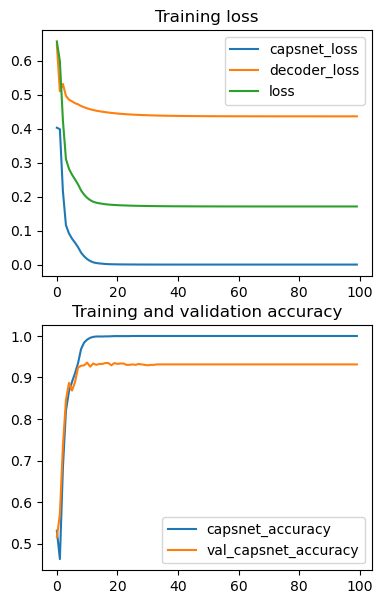

In [16]:
#define model
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model, eval_model = CapsNet(input_shape=x_train.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_train, 1))),
                                              routings=7,
                                              batch_size=20)

    train(model=model, data=((x_train, y_train), (x_test, y_test)), args=None)

##### Test

In [15]:
model, eval_model = CapsNet(input_shape=x_test.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_test, 1))),
                                              routings=7,
                                              batch_size=20)
model_= model
model_.load_weights('result/trained_model_july1.h5')
model_.compile(optimizer=optimizers.Adam(lr=0.0010646209),
                  loss=[margin_loss, 'binary_crossentropy'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})
label_predicted,image_predicted = model_.predict((x_test, y_test),20)

2023-07-24 21:35:22.511642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 21:35:24.201630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14759 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-07-24 21:35:24.202262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14759 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-24 21:35:24.202746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

(20, 165888, 8)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-07-24 21:35:26.706445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


46/46 [==============================] - 7s 100ms/step


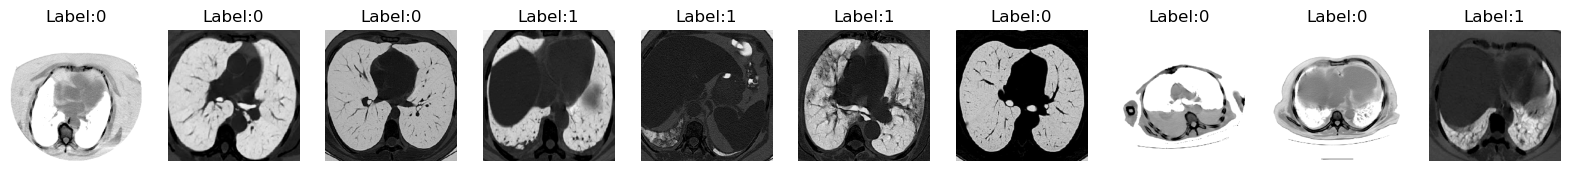

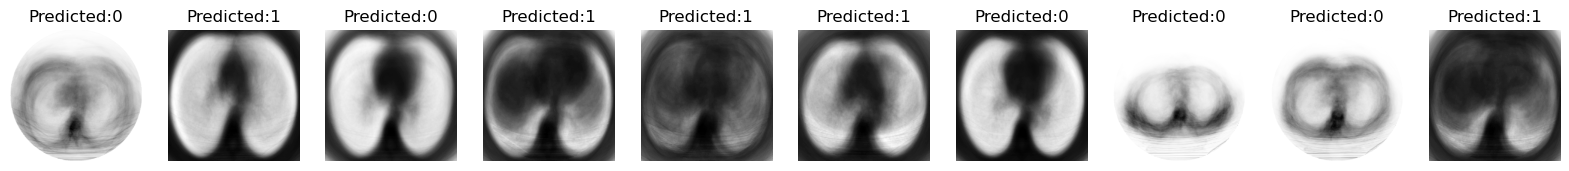

In [16]:
n_samples = 10

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_test[index].reshape(300, 300)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(y_test[index].argmax()))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = image_predicted[index].reshape(300, 300)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Predicted:" + str(np.argmax(label_predicted[index])))
    plt.axis("off")

plt.show()

In [14]:
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'
        
def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels,image_predicted = model.predict((test_features_, test_labels_),20)
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    # df['Probality'] = np.max(np.array(df.iloc[:,:7]))
    #df.drop([0,1,2,3,4,5,6,7,8,9],axis =1,inplace=True)
    #print(df.head(100))
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()
    
    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    #pred_list = [i for i in range(test_labels_.shape[0]) if test_labels__[i] is predicted_labels[i]]

#     pred = model.evaluate(test_features_,test_labels_)
#     print("loss = " + str(pred[0]))
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__, 
                    predicted_labels=predictions)
    

46/46 [==============================] - 5s 101ms/step


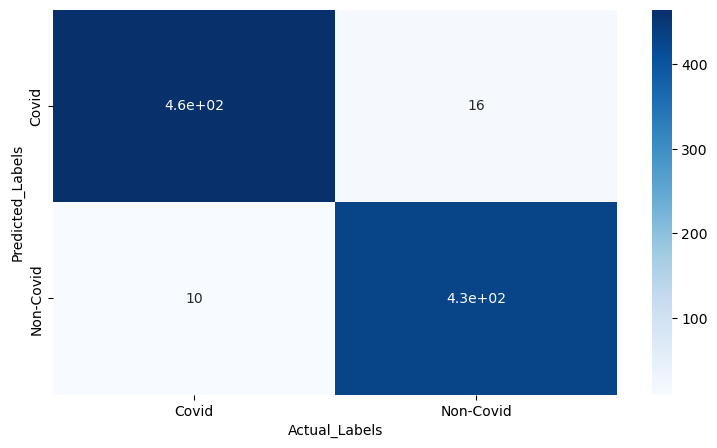

test accuracy = 97.17391304347827%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9717
Precision: 0.9718
Recall: 0.9717
F1 Score: 0.9717


In [18]:
import seaborn as sns
getModelEvaluation(model_,x_test,y_test)

### Testing the Trained Model on a different Dataset
- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset

In [15]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))

path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_NonCOVID/'
prefix2 = 'ct_noncovid'

def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df


ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
display(cvd_imgs_dataset)

input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((14486,300,300,1))#dataset1=746
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
cvd_imgs_dataset_ = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
output_label_y = np.array(cvd_imgs_dataset_[['output_encode_0','output_encode_1']])
#output_label_y = np.array(cvd_imgs_dataset[['output_encode']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))
#print('Output_y Data Shape for evaluation: \n{0}'.format(output_label_y_eval.shape))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


,0,1,2,3,4,5,6,7,8,9,...,89991,89992,89993,89994,89995,89996,89997,89998,89999,class_label
ct_covid_4626.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ct_covid_1391.png,4,5,0,4,1,2,1,2,2,2,...,12,14,13,13,12,15,15,12,14,1
ct_noncovid_5349.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_covid_1678.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ct_covid_1199.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ct_noncovid_2267.png,1,5,6,0,0,3,3,1,2,0,...,0,6,0,6,1,2,5,9,7,0
ct_covid_4754.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ct_noncovid_6798.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_452.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Input_x Data Shape: 
(14486, 300, 300, 1)
Output_y Data Shape: 
(14486, 2)


In [16]:
def splitData(input_data_x_, output_label_y_):
    x_train, x_test, y_train, y_test = train_test_split(input_data_x_, output_label_y_, test_size=.20, random_state=42)
    return (x_train, x_test), (y_train, y_test)

In [17]:
def get_data():
    # the data, shuffled and split between train and test sets
    from tensorflow.keras.datasets import mnist
    (x_train, x_test), (y_train, y_test) = splitData(input_data_x, output_label_y)
    #return x_train, x_test, y_train, y_test
    #11580
    x_train = x_train[0:5000,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    x_test = x_test[0:2880,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    y_train = y_train.astype('float32')[0:5000,:]
    y_test = y_test.astype('float32')[0:2880,:]
    return (x_train, y_train), (x_test, y_test)

# load data
(x_train_gen_2, y_train_gen_2), (x_test_gen_2, y_test_gen_2) = get_data()
print(x_train_gen_2.shape, y_train_gen_2.shape,x_test_gen_2.shape, y_test_gen_2.shape)
#(3254, 300, 300, 1) (3254, 2) (1395, 300, 300, 1) (1395, 2)]=[;-----p]

(5000, 300, 300, 1) (5000, 2) (2880, 300, 300, 1) (2880, 2)


### Loading Trained Model on old dataset

In [22]:
model, eval_model = CapsNet(input_shape=x_test.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_test, 1))),
                                              routings=7,
                                              batch_size=20)
model_= model
model_.load_weights('result/trained_model_july1.h5')
model_.compile(optimizer=optimizers.Adam(lr=0.0010646209),
                  loss=[margin_loss, 'binary_crossentropy'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})

(20, 165888, 8)


In [23]:
label_predicted,image_predicted = model_.predict((x_test_gen_2, y_test_gen_2),20)

144/144 [==============================] - 15s 101ms/step


144/144 [==============================] - 15s 102ms/step


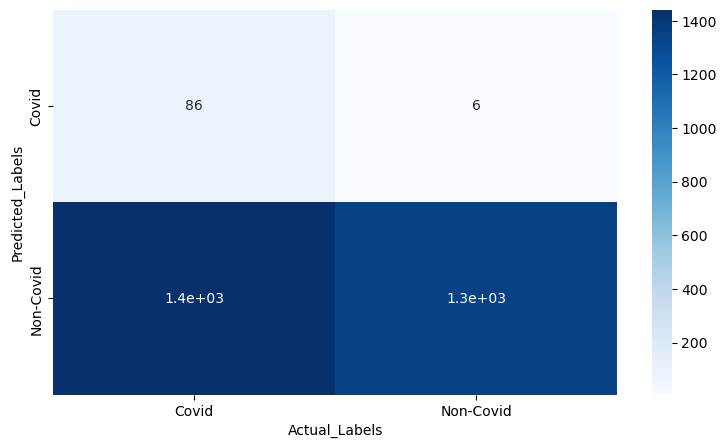

test accuracy = 49.75694444444444%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4976
Precision: 0.7226
Recall: 0.4976
F1 Score: 0.362


In [24]:
import seaborn as sns
getModelEvaluation(model_,x_test_gen_2, y_test_gen_2)

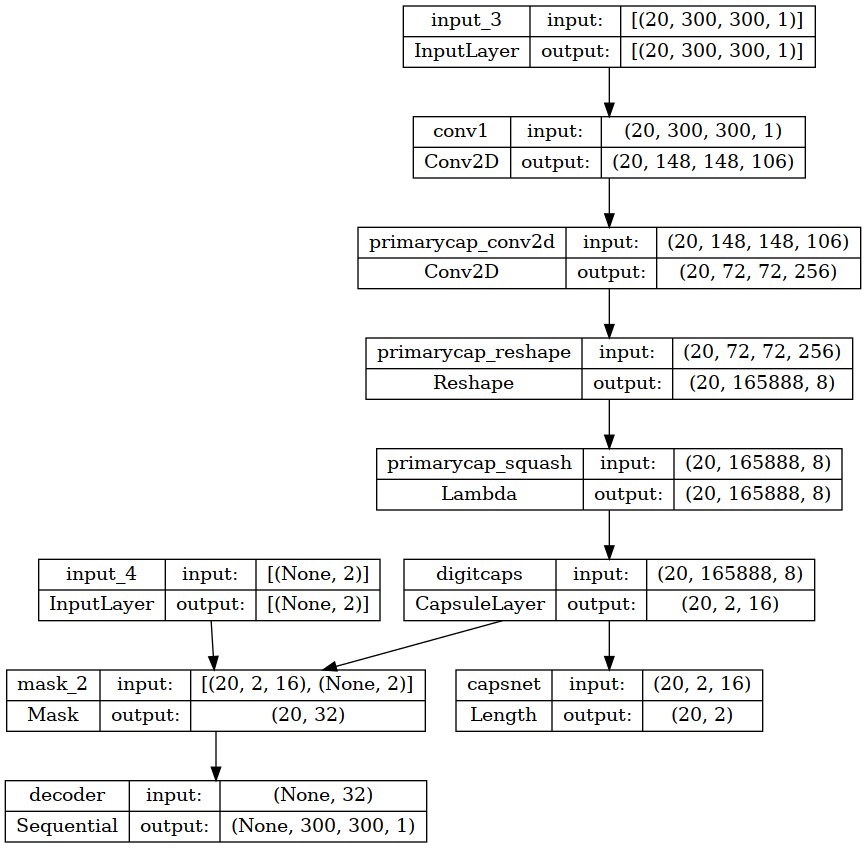

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model_, to_file='capsule_gen_1_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
layers__ = [(layer, layer.name, layer.trainable) for layer in model_.layers]
pd.DataFrame(layers__, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,True
1,<keras.layers.convolutional.conv2d.Conv2D obje...,conv1,True
2,<keras.layers.convolutional.conv2d.Conv2D obje...,primarycap_conv2d,True
3,<keras.layers.reshaping.reshape.Reshape object...,primarycap_reshape,True
4,<keras.layers.core.lambda_layer.Lambda object ...,primarycap_squash,True
5,<__main__.CapsuleLayer object at 0x7f6d5c5ccd00>,digitcaps,True
6,<keras.engine.input_layer.InputLayer object at...,input_4,True
7,<__main__.Mask object at 0x7f6d54257280>,mask_2,True
8,<__main__.Length object at 0x7f6d5c6e9d60>,capsnet,True
9,<keras.engine.sequential.Sequential object at ...,decoder,True


In [27]:
model_.layers[5].output

<KerasTensor: shape=(20, 2, 16) dtype=float32 (created by layer 'digitcaps')>

### Generaliing the Model on new Dataset 1 via Transfer Learning (using pre-trained weights from Task1 Model)

In [20]:
for layer in layers_to_keep:
    print(layer.name)

input_1
conv1
primarycap_conv2d
primarycap_reshape
primarycap_squash
digitcaps
input_2
mask
capsnet


In [18]:
n_class=len(np.unique(np.argmax(y_test_gen_2, 1)))
model, eval_model = CapsNet(input_shape=x_test_gen_2.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_test_gen_2, 1))),
                                              routings=7,#7
                                              batch_size=20)
model_= model
model_.load_weights('result/trained_model_july1.h5')
input_shape=x_test.shape[1:]

# Step 2: Identify the layers to keep (e.g., excluding the last fully connected layer)
layers_to_keep = model_.layers[0:]

#getting the input and output tensor from old model to create new model_without fully connected layers
input_tensor = model_.input
# Freeze the pre-trained layers
for layer in layers_to_keep:
    layer.trainable = False
train_model_gen = models.Model(input_tensor, [model_.layers[8].output, model_.layers[9](model_.layers[7].output)])
train_model_gen.layers[9].trainable=True
train_model_gen.layers[8].trainable=True
train_model_gen.layers[7].trainable=True
train_model_gen.layers[5].trainable=True

2023-07-25 16:20:43.205021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 16:20:44.748716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14759 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-07-25 16:20:44.749401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14759 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-25 16:20:44.749851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

(20, 165888, 8)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


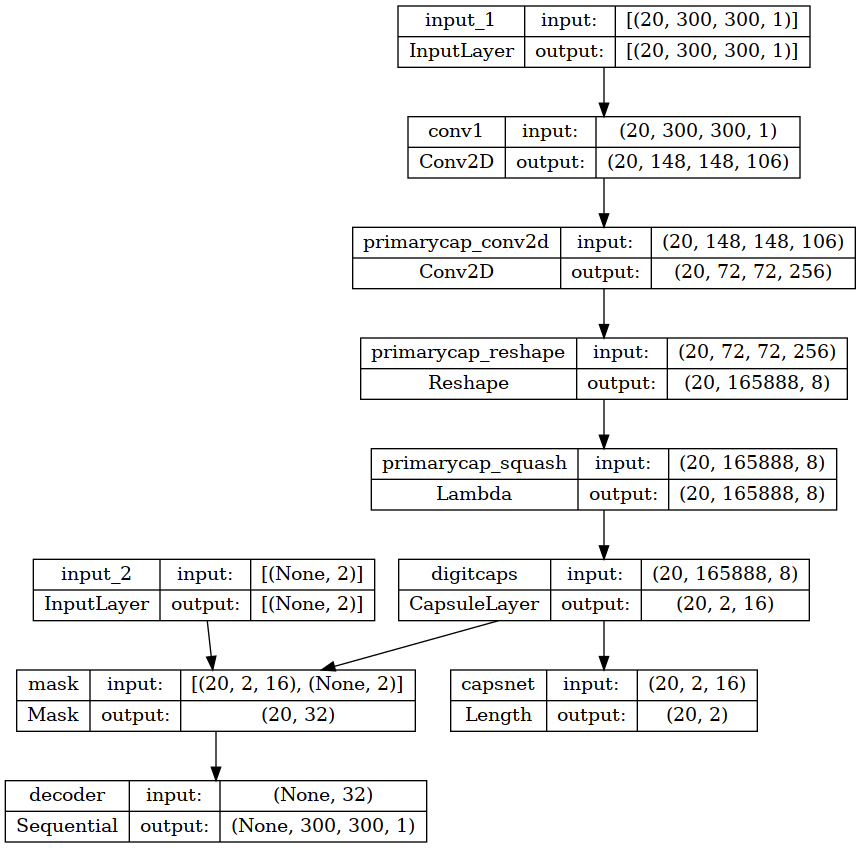

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(train_model_gen, to_file='capsule_gen_tmp_1_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
layers__ = [(layer, layer.name, layer.trainable) for layer in train_model_gen.layers]
pd.DataFrame(layers__, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D obje...,conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D obje...,primarycap_conv2d,False
3,<keras.layers.reshaping.reshape.Reshape object...,primarycap_reshape,False
4,<keras.layers.core.lambda_layer.Lambda object ...,primarycap_squash,False
5,<__main__.CapsuleLayer object at 0x7fee98576dc0>,digitcaps,True
6,<keras.engine.input_layer.InputLayer object at...,input_2,False
7,<__main__.Mask object at 0x7fee985c3580>,mask,True
8,<__main__.Length object at 0x7fee9bf47f70>,capsnet,True
9,<keras.engine.sequential.Sequential object at ...,decoder,True


In [21]:
def train_gen(model,  # type: models.Model
          data, args=None):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('result/log_gen.csv')
    checkpoint = callbacks.ModelCheckpoint('result'+ '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * (0.9 ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=0.0010646209),
                  loss=[margin_loss, 'binary_crossentropy'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})


#     # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=20, epochs=50,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, checkpoint, lr_decay])
    
    model.save_weights('result' + '/trained_model_gen_july1.h5')
    print('Trained model saved to \'%s/trained_model_gen_july1.h5\'' % 'result')

    from utils import plot_log
    plot_log('result' + '/log_gen.csv', show=True)

    return model

Epoch 1/50


2023-07-25 16:20:51.410239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-25 16:20:52.685416: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe46a0ea8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-25 16:20:52.685445: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-07-25 16:20:52.685450: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-07-25 16:20:52.685453: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2023-07-25 16:20:52.685456: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): Quadro RTX 5000, Compute Capability 7.5
2023-07-25 16:20:52.689376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabl

250/250 [==============================] - ETA: 0s - loss: 0.3000 - capsnet_loss: 0.1105 - decoder_loss: 0.4836 - capsnet_accuracy: 0.8592WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 85s 322ms/step - loss: 0.3000 - capsnet_loss: 0.1105 - decoder_loss: 0.4836 - capsnet_accuracy: 0.8592 - val_loss: 0.2640 - val_capsnet_loss: 0.0799 - val_decoder_loss: 0.4697 - val_capsnet_accuracy: 0.9153 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.2347 - capsnet_loss: 0.0515 - decoder_loss: 0.4674 - capsnet_accuracy: 0.9500WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.2347 - capsnet_loss: 0.0515 - decoder_loss: 0.4674 - capsnet_accuracy: 0.9500 - val_loss: 0.2459 - val_capsnet_loss: 0.0634 - val_decoder_loss: 0.4654 - val_capsnet_accuracy: 0.9285 - lr: 9.0000e-04
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.2156 - capsnet_loss: 0.0344 - decoder_loss: 0.4623 - capsnet_accuracy: 0.9734WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.2156 - capsnet_loss: 0.0344 - decoder_loss: 0.4623 - capsnet_accuracy: 0.9734 - val_loss: 0.2367 - val_capsnet_loss: 0.0557 - val_decoder_loss: 0.4617 - val_capsnet_accuracy: 0.9431 - lr: 8.1000e-04
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.2071 - capsnet_loss: 0.0270 - decoder_loss: 0.4595 - capsnet_accuracy: 0.9866WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.2071 - capsnet_loss: 0.0270 - decoder_loss: 0.4595 - capsnet_accuracy: 0.9866 - val_loss: 0.2318 - val_capsnet_loss: 0.0516 - val_decoder_loss: 0.4597 - val_capsnet_accuracy: 0.9521 - lr: 7.2900e-04
Epoch 5/50
250/250 [==============================] - ETA: 0s - loss: 0.2009 - capsnet_loss: 0.0215 - decoder_loss: 0.4575 - capsnet_accuracy: 0.9904WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.2009 - capsnet_loss: 0.0215 - decoder_loss: 0.4575 - capsnet_accuracy: 0.9904 - val_loss: 0.2307 - val_capsnet_loss: 0.0509 - val_decoder_loss: 0.4587 - val_capsnet_accuracy: 0.9545 - lr: 6.5610e-04
Epoch 6/50
250/250 [==============================] - ETA: 0s - loss: 0.1977 - capsnet_loss: 0.0189 - decoder_loss: 0.4561 - capsnet_accuracy: 0.9944WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1977 - capsnet_loss: 0.0189 - decoder_loss: 0.4561 - capsnet_accuracy: 0.9944 - val_loss: 0.2268 - val_capsnet_loss: 0.0476 - val_decoder_loss: 0.4572 - val_capsnet_accuracy: 0.9597 - lr: 5.9049e-04
Epoch 7/50
250/250 [==============================] - ETA: 0s - loss: 0.1932 - capsnet_loss: 0.0149 - decoder_loss: 0.4548 - capsnet_accuracy: 0.9962WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1932 - capsnet_loss: 0.0149 - decoder_loss: 0.4548 - capsnet_accuracy: 0.9962 - val_loss: 0.2262 - val_capsnet_loss: 0.0473 - val_decoder_loss: 0.4564 - val_capsnet_accuracy: 0.9625 - lr: 5.3144e-04
Epoch 8/50
250/250 [==============================] - ETA: 0s - loss: 0.1904 - capsnet_loss: 0.0126 - decoder_loss: 0.4537 - capsnet_accuracy: 0.9970WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1904 - capsnet_loss: 0.0126 - decoder_loss: 0.4537 - capsnet_accuracy: 0.9970 - val_loss: 0.2246 - val_capsnet_loss: 0.0460 - val_decoder_loss: 0.4556 - val_capsnet_accuracy: 0.9639 - lr: 4.7830e-04
Epoch 9/50
250/250 [==============================] - ETA: 0s - loss: 0.1879 - capsnet_loss: 0.0105 - decoder_loss: 0.4527 - capsnet_accuracy: 0.9980WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1879 - capsnet_loss: 0.0105 - decoder_loss: 0.4527 - capsnet_accuracy: 0.9980 - val_loss: 0.2235 - val_capsnet_loss: 0.0453 - val_decoder_loss: 0.4546 - val_capsnet_accuracy: 0.9597 - lr: 4.3047e-04
Epoch 10/50
250/250 [==============================] - ETA: 0s - loss: 0.1861 - capsnet_loss: 0.0089 - decoder_loss: 0.4520 - capsnet_accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1861 - capsnet_loss: 0.0089 - decoder_loss: 0.4520 - capsnet_accuracy: 0.9984 - val_loss: 0.2251 - val_capsnet_loss: 0.0470 - val_decoder_loss: 0.4543 - val_capsnet_accuracy: 0.9601 - lr: 3.8742e-04
Epoch 11/50
250/250 [==============================] - ETA: 0s - loss: 0.1843 - capsnet_loss: 0.0074 - decoder_loss: 0.4513 - capsnet_accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1843 - capsnet_loss: 0.0074 - decoder_loss: 0.4513 - capsnet_accuracy: 0.9988 - val_loss: 0.2233 - val_capsnet_loss: 0.0455 - val_decoder_loss: 0.4537 - val_capsnet_accuracy: 0.9635 - lr: 3.4868e-04
Epoch 12/50
250/250 [==============================] - ETA: 0s - loss: 0.1829 - capsnet_loss: 0.0063 - decoder_loss: 0.4507 - capsnet_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1829 - capsnet_loss: 0.0063 - decoder_loss: 0.4507 - capsnet_accuracy: 0.9992 - val_loss: 0.2240 - val_capsnet_loss: 0.0464 - val_decoder_loss: 0.4531 - val_capsnet_accuracy: 0.9663 - lr: 3.1381e-04
Epoch 13/50
250/250 [==============================] - ETA: 0s - loss: 0.1819 - capsnet_loss: 0.0054 - decoder_loss: 0.4502 - capsnet_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1819 - capsnet_loss: 0.0054 - decoder_loss: 0.4502 - capsnet_accuracy: 0.9992 - val_loss: 0.2226 - val_capsnet_loss: 0.0451 - val_decoder_loss: 0.4529 - val_capsnet_accuracy: 0.9632 - lr: 2.8243e-04
Epoch 14/50
250/250 [==============================] - ETA: 0s - loss: 0.1811 - capsnet_loss: 0.0048 - decoder_loss: 0.4498 - capsnet_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1811 - capsnet_loss: 0.0048 - decoder_loss: 0.4498 - capsnet_accuracy: 0.9992 - val_loss: 0.2228 - val_capsnet_loss: 0.0454 - val_decoder_loss: 0.4527 - val_capsnet_accuracy: 0.9642 - lr: 2.5419e-04
Epoch 15/50
250/250 [==============================] - ETA: 0s - loss: 0.1800 - capsnet_loss: 0.0039 - decoder_loss: 0.4494 - capsnet_accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1800 - capsnet_loss: 0.0039 - decoder_loss: 0.4494 - capsnet_accuracy: 0.9992 - val_loss: 0.2227 - val_capsnet_loss: 0.0455 - val_decoder_loss: 0.4523 - val_capsnet_accuracy: 0.9653 - lr: 2.2877e-04
Epoch 16/50
250/250 [==============================] - ETA: 0s - loss: 0.1794 - capsnet_loss: 0.0034 - decoder_loss: 0.4490 - capsnet_accuracy: 0.9994WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1794 - capsnet_loss: 0.0034 - decoder_loss: 0.4490 - capsnet_accuracy: 0.9994 - val_loss: 0.2233 - val_capsnet_loss: 0.0461 - val_decoder_loss: 0.4520 - val_capsnet_accuracy: 0.9639 - lr: 2.0589e-04
Epoch 17/50
250/250 [==============================] - ETA: 0s - loss: 0.1789 - capsnet_loss: 0.0030 - decoder_loss: 0.4487 - capsnet_accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1789 - capsnet_loss: 0.0030 - decoder_loss: 0.4487 - capsnet_accuracy: 0.9996 - val_loss: 0.2237 - val_capsnet_loss: 0.0466 - val_decoder_loss: 0.4519 - val_capsnet_accuracy: 0.9667 - lr: 1.8530e-04
Epoch 18/50
250/250 [==============================] - ETA: 0s - loss: 0.1784 - capsnet_loss: 0.0026 - decoder_loss: 0.4484 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1784 - capsnet_loss: 0.0026 - decoder_loss: 0.4484 - capsnet_accuracy: 0.9998 - val_loss: 0.2234 - val_capsnet_loss: 0.0463 - val_decoder_loss: 0.4518 - val_capsnet_accuracy: 0.9649 - lr: 1.6677e-04
Epoch 19/50
250/250 [==============================] - ETA: 0s - loss: 0.1781 - capsnet_loss: 0.0024 - decoder_loss: 0.4481 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1781 - capsnet_loss: 0.0024 - decoder_loss: 0.4481 - capsnet_accuracy: 0.9998 - val_loss: 0.2231 - val_capsnet_loss: 0.0462 - val_decoder_loss: 0.4515 - val_capsnet_accuracy: 0.9653 - lr: 1.5009e-04
Epoch 20/50
250/250 [==============================] - ETA: 0s - loss: 0.1777 - capsnet_loss: 0.0022 - decoder_loss: 0.4479 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1777 - capsnet_loss: 0.0022 - decoder_loss: 0.4479 - capsnet_accuracy: 0.9998 - val_loss: 0.2237 - val_capsnet_loss: 0.0467 - val_decoder_loss: 0.4514 - val_capsnet_accuracy: 0.9642 - lr: 1.3509e-04
Epoch 21/50
250/250 [==============================] - ETA: 0s - loss: 0.1775 - capsnet_loss: 0.0020 - decoder_loss: 0.4477 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 78s 314ms/step - loss: 0.1775 - capsnet_loss: 0.0020 - decoder_loss: 0.4477 - capsnet_accuracy: 0.9998 - val_loss: 0.2238 - val_capsnet_loss: 0.0470 - val_decoder_loss: 0.4512 - val_capsnet_accuracy: 0.9649 - lr: 1.2158e-04
Epoch 22/50
250/250 [==============================] - ETA: 0s - loss: 0.1773 - capsnet_loss: 0.0019 - decoder_loss: 0.4475 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1773 - capsnet_loss: 0.0019 - decoder_loss: 0.4475 - capsnet_accuracy: 0.9998 - val_loss: 0.2238 - val_capsnet_loss: 0.0470 - val_decoder_loss: 0.4511 - val_capsnet_accuracy: 0.9656 - lr: 1.0942e-04
Epoch 23/50
250/250 [==============================] - ETA: 0s - loss: 0.1770 - capsnet_loss: 0.0017 - decoder_loss: 0.4473 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1770 - capsnet_loss: 0.0017 - decoder_loss: 0.4473 - capsnet_accuracy: 0.9998 - val_loss: 0.2240 - val_capsnet_loss: 0.0472 - val_decoder_loss: 0.4510 - val_capsnet_accuracy: 0.9667 - lr: 9.8477e-05
Epoch 24/50
250/250 [==============================] - ETA: 0s - loss: 0.1768 - capsnet_loss: 0.0016 - decoder_loss: 0.4471 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1768 - capsnet_loss: 0.0016 - decoder_loss: 0.4471 - capsnet_accuracy: 0.9998 - val_loss: 0.2242 - val_capsnet_loss: 0.0475 - val_decoder_loss: 0.4509 - val_capsnet_accuracy: 0.9663 - lr: 8.8629e-05
Epoch 25/50
250/250 [==============================] - ETA: 0s - loss: 0.1767 - capsnet_loss: 0.0015 - decoder_loss: 0.4470 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1767 - capsnet_loss: 0.0015 - decoder_loss: 0.4470 - capsnet_accuracy: 0.9998 - val_loss: 0.2244 - val_capsnet_loss: 0.0477 - val_decoder_loss: 0.4508 - val_capsnet_accuracy: 0.9653 - lr: 7.9766e-05
Epoch 26/50
250/250 [==============================] - ETA: 0s - loss: 0.1765 - capsnet_loss: 0.0014 - decoder_loss: 0.4469 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1765 - capsnet_loss: 0.0014 - decoder_loss: 0.4469 - capsnet_accuracy: 0.9998 - val_loss: 0.2247 - val_capsnet_loss: 0.0481 - val_decoder_loss: 0.4507 - val_capsnet_accuracy: 0.9653 - lr: 7.1790e-05
Epoch 27/50
250/250 [==============================] - ETA: 0s - loss: 0.1764 - capsnet_loss: 0.0013 - decoder_loss: 0.4467 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1764 - capsnet_loss: 0.0013 - decoder_loss: 0.4467 - capsnet_accuracy: 0.9998 - val_loss: 0.2245 - val_capsnet_loss: 0.0478 - val_decoder_loss: 0.4506 - val_capsnet_accuracy: 0.9653 - lr: 6.4611e-05
Epoch 28/50
250/250 [==============================] - ETA: 0s - loss: 0.1763 - capsnet_loss: 0.0012 - decoder_loss: 0.4466 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1763 - capsnet_loss: 0.0012 - decoder_loss: 0.4466 - capsnet_accuracy: 0.9998 - val_loss: 0.2248 - val_capsnet_loss: 0.0481 - val_decoder_loss: 0.4506 - val_capsnet_accuracy: 0.9653 - lr: 5.8150e-05
Epoch 29/50
250/250 [==============================] - ETA: 0s - loss: 0.1762 - capsnet_loss: 0.0012 - decoder_loss: 0.4465 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1762 - capsnet_loss: 0.0012 - decoder_loss: 0.4465 - capsnet_accuracy: 0.9998 - val_loss: 0.2248 - val_capsnet_loss: 0.0482 - val_decoder_loss: 0.4505 - val_capsnet_accuracy: 0.9663 - lr: 5.2335e-05
Epoch 30/50
250/250 [==============================] - ETA: 0s - loss: 0.1762 - capsnet_loss: 0.0011 - decoder_loss: 0.4464 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1762 - capsnet_loss: 0.0011 - decoder_loss: 0.4464 - capsnet_accuracy: 0.9998 - val_loss: 0.2248 - val_capsnet_loss: 0.0482 - val_decoder_loss: 0.4505 - val_capsnet_accuracy: 0.9653 - lr: 4.7101e-05
Epoch 31/50
250/250 [==============================] - ETA: 0s - loss: 0.1761 - capsnet_loss: 0.0011 - decoder_loss: 0.4464 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1761 - capsnet_loss: 0.0011 - decoder_loss: 0.4464 - capsnet_accuracy: 0.9998 - val_loss: 0.2250 - val_capsnet_loss: 0.0484 - val_decoder_loss: 0.4504 - val_capsnet_accuracy: 0.9656 - lr: 4.2391e-05
Epoch 32/50
250/250 [==============================] - ETA: 0s - loss: 0.1760 - capsnet_loss: 0.0011 - decoder_loss: 0.4463 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1760 - capsnet_loss: 0.0011 - decoder_loss: 0.4463 - capsnet_accuracy: 0.9998 - val_loss: 0.2250 - val_capsnet_loss: 0.0484 - val_decoder_loss: 0.4504 - val_capsnet_accuracy: 0.9663 - lr: 3.8152e-05
Epoch 33/50
250/250 [==============================] - ETA: 0s - loss: 0.1760 - capsnet_loss: 0.0010 - decoder_loss: 0.4462 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1760 - capsnet_loss: 0.0010 - decoder_loss: 0.4462 - capsnet_accuracy: 0.9998 - val_loss: 0.2251 - val_capsnet_loss: 0.0486 - val_decoder_loss: 0.4503 - val_capsnet_accuracy: 0.9660 - lr: 3.4337e-05
Epoch 34/50
250/250 [==============================] - ETA: 0s - loss: 0.1759 - capsnet_loss: 0.0010 - decoder_loss: 0.4462 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1759 - capsnet_loss: 0.0010 - decoder_loss: 0.4462 - capsnet_accuracy: 0.9998 - val_loss: 0.2252 - val_capsnet_loss: 0.0487 - val_decoder_loss: 0.4503 - val_capsnet_accuracy: 0.9660 - lr: 3.0903e-05
Epoch 35/50
250/250 [==============================] - ETA: 0s - loss: 0.1759 - capsnet_loss: 9.8777e-04 - decoder_loss: 0.4461 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1759 - capsnet_loss: 9.8777e-04 - decoder_loss: 0.4461 - capsnet_accuracy: 0.9998 - val_loss: 0.2252 - val_capsnet_loss: 0.0487 - val_decoder_loss: 0.4503 - val_capsnet_accuracy: 0.9660 - lr: 2.7813e-05
Epoch 36/50
250/250 [==============================] - ETA: 0s - loss: 0.1758 - capsnet_loss: 9.6628e-04 - decoder_loss: 0.4460 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1758 - capsnet_loss: 9.6628e-04 - decoder_loss: 0.4460 - capsnet_accuracy: 0.9998 - val_loss: 0.2252 - val_capsnet_loss: 0.0487 - val_decoder_loss: 0.4503 - val_capsnet_accuracy: 0.9656 - lr: 2.5032e-05
Epoch 37/50
250/250 [==============================] - ETA: 0s - loss: 0.1758 - capsnet_loss: 9.4320e-04 - decoder_loss: 0.4460 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1758 - capsnet_loss: 9.4320e-04 - decoder_loss: 0.4460 - capsnet_accuracy: 0.9998 - val_loss: 0.2253 - val_capsnet_loss: 0.0488 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9656 - lr: 2.2528e-05
Epoch 38/50
250/250 [==============================] - ETA: 0s - loss: 0.1757 - capsnet_loss: 9.2844e-04 - decoder_loss: 0.4460 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1757 - capsnet_loss: 9.2844e-04 - decoder_loss: 0.4460 - capsnet_accuracy: 0.9998 - val_loss: 0.2254 - val_capsnet_loss: 0.0489 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9660 - lr: 2.0276e-05
Epoch 39/50
250/250 [==============================] - ETA: 0s - loss: 0.1757 - capsnet_loss: 9.1285e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1757 - capsnet_loss: 9.1285e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9998 - val_loss: 0.2255 - val_capsnet_loss: 0.0490 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9663 - lr: 1.8248e-05
Epoch 40/50
250/250 [==============================] - ETA: 0s - loss: 0.1757 - capsnet_loss: 8.9472e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1757 - capsnet_loss: 8.9472e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9998 - val_loss: 0.2257 - val_capsnet_loss: 0.0492 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9667 - lr: 1.6423e-05
Epoch 41/50
250/250 [==============================] - ETA: 0s - loss: 0.1757 - capsnet_loss: 8.8325e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1757 - capsnet_loss: 8.8325e-04 - decoder_loss: 0.4459 - capsnet_accuracy: 0.9998 - val_loss: 0.2255 - val_capsnet_loss: 0.0491 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9660 - lr: 1.4781e-05
Epoch 42/50
250/250 [==============================] - ETA: 0s - loss: 0.1756 - capsnet_loss: 8.6636e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1756 - capsnet_loss: 8.6636e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998 - val_loss: 0.2256 - val_capsnet_loss: 0.0492 - val_decoder_loss: 0.4502 - val_capsnet_accuracy: 0.9656 - lr: 1.3303e-05
Epoch 43/50
250/250 [==============================] - ETA: 0s - loss: 0.1756 - capsnet_loss: 8.5701e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1756 - capsnet_loss: 8.5701e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998 - val_loss: 0.2257 - val_capsnet_loss: 0.0492 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9660 - lr: 1.1973e-05
Epoch 44/50
250/250 [==============================] - ETA: 0s - loss: 0.1756 - capsnet_loss: 8.4572e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1756 - capsnet_loss: 8.4572e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998 - val_loss: 0.2256 - val_capsnet_loss: 0.0492 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9656 - lr: 1.0775e-05
Epoch 45/50
250/250 [==============================] - ETA: 0s - loss: 0.1756 - capsnet_loss: 8.3664e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1756 - capsnet_loss: 8.3664e-04 - decoder_loss: 0.4458 - capsnet_accuracy: 0.9998 - val_loss: 0.2257 - val_capsnet_loss: 0.0493 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9656 - lr: 9.6977e-06
Epoch 46/50
250/250 [==============================] - ETA: 0s - loss: 0.1756 - capsnet_loss: 8.2830e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1756 - capsnet_loss: 8.2830e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998 - val_loss: 0.2257 - val_capsnet_loss: 0.0492 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9656 - lr: 8.7280e-06
Epoch 47/50
250/250 [==============================] - ETA: 0s - loss: 0.1755 - capsnet_loss: 8.1779e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1755 - capsnet_loss: 8.1779e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998 - val_loss: 0.2260 - val_capsnet_loss: 0.0496 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9663 - lr: 7.8552e-06
Epoch 48/50
250/250 [==============================] - ETA: 0s - loss: 0.1755 - capsnet_loss: 8.1600e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 314ms/step - loss: 0.1755 - capsnet_loss: 8.1600e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998 - val_loss: 0.2258 - val_capsnet_loss: 0.0494 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9660 - lr: 7.0697e-06
Epoch 49/50
250/250 [==============================] - ETA: 0s - loss: 0.1755 - capsnet_loss: 8.0803e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1755 - capsnet_loss: 8.0803e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998 - val_loss: 0.2259 - val_capsnet_loss: 0.0495 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9660 - lr: 6.3627e-06
Epoch 50/50
250/250 [==============================] - ETA: 0s - loss: 0.1755 - capsnet_loss: 8.0175e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_capsnet_acc available, skipping.


250/250 [==============================] - 79s 315ms/step - loss: 0.1755 - capsnet_loss: 8.0175e-04 - decoder_loss: 0.4457 - capsnet_accuracy: 0.9998 - val_loss: 0.2259 - val_capsnet_loss: 0.0494 - val_decoder_loss: 0.4501 - val_capsnet_accuracy: 0.9660 - lr: 5.7264e-06
Trained model saved to 'result/trained_model_gen_july1.h5'


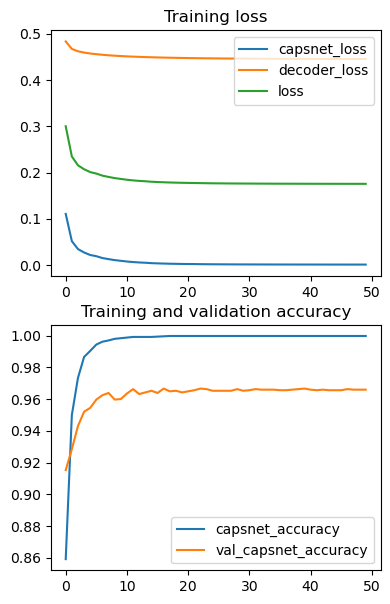

In [22]:
train_gen(model=train_model_gen, data=((x_train_gen_2, y_train_gen_2), (x_test_gen_2, y_test_gen_2)), args=None)

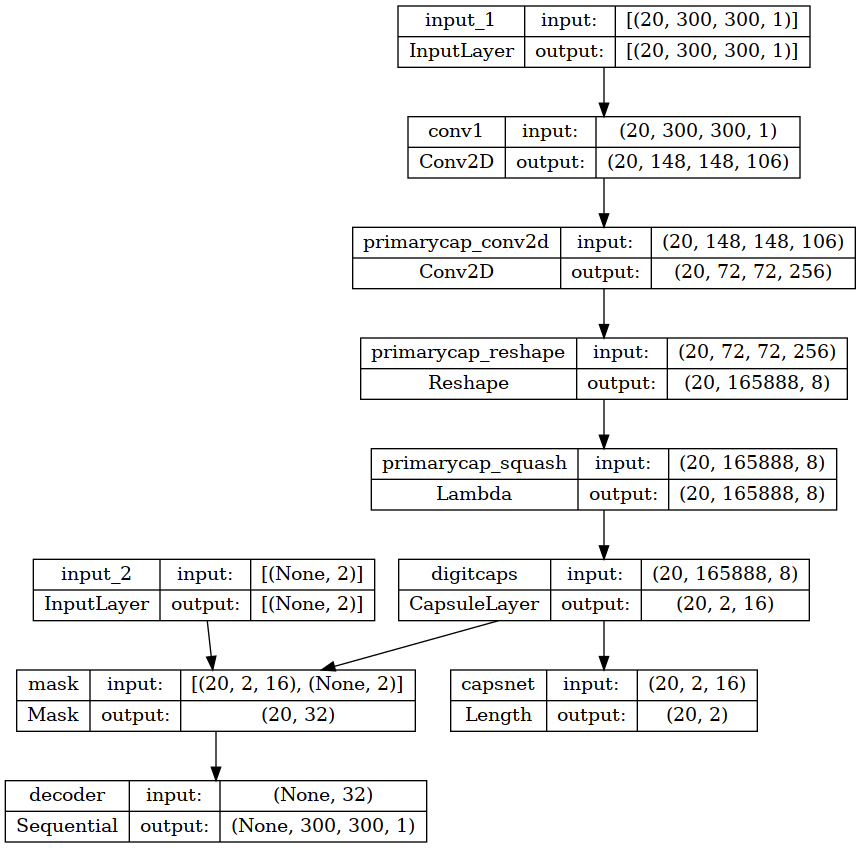

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(train_model_gen, to_file='capsule_1_gen_plot.png', show_shapes=True, show_layer_names=True)

144/144 [==============================] - 15s 101ms/step


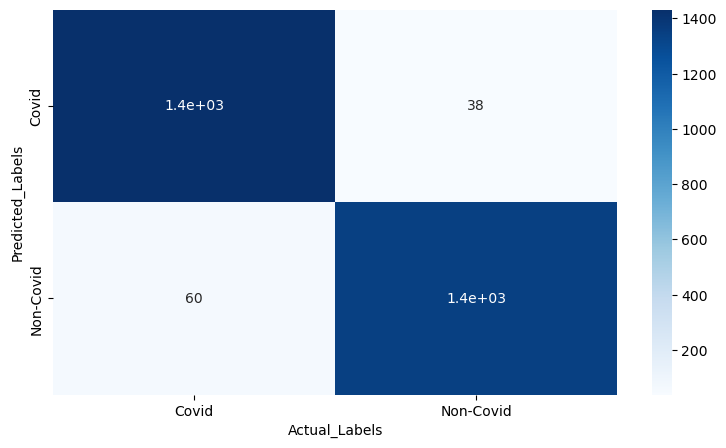

test accuracy = 96.59722222222223%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.966
Precision: 0.9661
Recall: 0.966
F1 Score: 0.966


In [23]:
import seaborn as sns
getModelEvaluation(train_model_gen,x_test_gen_2, y_test_gen_2)

#### Testing the Generalized model on Dataset 1 (Task 1)

46/46 [==============================] - 5s 101ms/step


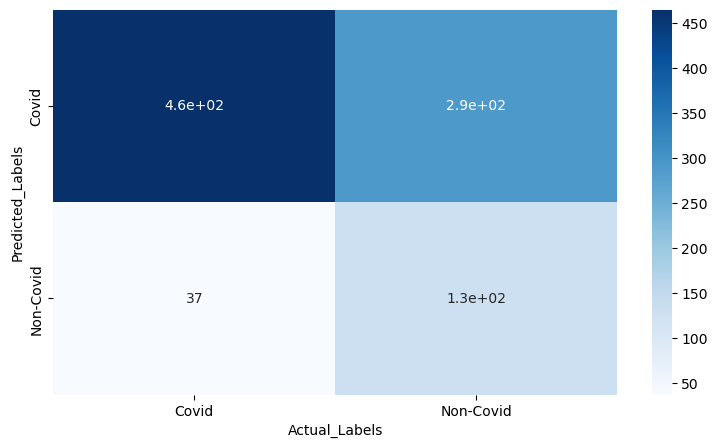

test accuracy = 64.45652173913044%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6446
Precision: 0.6885
Recall: 0.6446
F1 Score: 0.6032


In [24]:
getModelEvaluation(train_model_gen,x_test, y_test)